# Electroencephalogram Signal Classification for action identification

**Author:** [Suvaditya Mukherjee](https://github.com/suvadityamuk)<br>
**Date created:** 2022/11/03<br>
**Last modified:** 2022/11/05<br>
**Description:** Training a Convolutional model to classify EEG signals produced by exposure to certain stimuli.

## Introduction

The following example explores how we can make a Convolution-based Neural Network to
perform classification on Electroencephalogram signals captured when subjects were
exposed to different stimuli.
We train a model from scratch since such signal-classification models are fairly scarce
in pre-trained format.
The data we use is sourced from the UC Berkeley-Biosense Lab where the data was collected
from 15 subjects at the same time.
Our process is as follows:

- Load the [UC Berkeley-Biosense Synchronized Brainwave Dataset](https://www.kaggle.com/datasets/berkeley-biosense/synchronized-brainwave-dataset)
- Visualize random samples from the data
- Pre-process, collate and scale the data to finally make a `tf.data.Dataset`
- Prepare class weights in order to tackle major imbalances
- Create a Conv1D and Dense-based model to perform classification
- Define callbacks and hyperparameters
- Train the model
- Plot metrics from History and perform evaluation

This example needs the following external dependencies (Gdown, Scikit-learn, Pandas,
Numpy, Matplotlib). You can install it via the following commands.

Gdown is an external package used to download large files from Google Drive. To know
more, you can refer to its [PyPi page here](https://pypi.org/project/gdown)

## Setup and Data Downloads

First, lets install our dependencies:

In [22]:
!pip install gdown -q
!pip install sklearn -q
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Next, lets download our dataset.
The gdown package makes it easy to download the data from Google Drive:

In [1]:
!gdown 1V5B7Bt6aJm0UHbR7cRKBEK8jx7lYPVuX
!# gdown will download eeg-data.csv onto the local drive for use. Total size of
!# eeg-data.csv is 105.7 MB

Downloading...
From (original): https://drive.google.com/uc?id=1V5B7Bt6aJm0UHbR7cRKBEK8jx7lYPVuX
From (redirected): https://drive.google.com/uc?id=1V5B7Bt6aJm0UHbR7cRKBEK8jx7lYPVuX&confirm=t&uuid=7780a34a-3613-4732-84d8-2334675b436b
To: /content/eeg-data.csv
100% 106M/106M [00:01<00:00, 60.9MB/s] 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random

QUALITY_THRESHOLD = 128
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

## Read data from `eeg-data.csv`

We use the Pandas library to read the `eeg-data.csv` file and display the first 5 rows
using the `.head()` command

In [3]:
eeg = pd.read_csv("eeg-data.csv")

We remove unlabeled samples from our dataset as they do not contribute to the model. We
also perform a `.drop()` operation on the columns that are not required for training data
preparation

In [4]:
unlabeled_eeg = eeg[eeg["label"] == "unlabeled"]
eeg = eeg.loc[eeg["label"] != "unlabeled"]
eeg = eeg.loc[eeg["label"] != "everyone paired"]

eeg.drop(
    [
        "indra_time",
        "Unnamed: 0",
        "browser_latency",
        "reading_time",
        "attention_esense",
        "meditation_esense",
        "updatedAt",
        "createdAt",
    ],
    axis=1,
    inplace=True,
)

eeg.reset_index(drop=True, inplace=True)
eeg.head()

,id,eeg_power,raw_values,signal_quality,label
0,7,"[56887.0, 45471.0, 20074.0, 5359.0, 22594.0, 7...","[99.0, 96.0, 91.0, 89.0, 91.0, 89.0, 87.0, 93....",0,blinkInstruction
1,5,"[11626.0, 60301.0, 5805.0, 15729.0, 4448.0, 33...","[23.0, 40.0, 64.0, 89.0, 86.0, 33.0, -14.0, -1...",0,blinkInstruction
2,1,"[15777.0, 33461.0, 21385.0, 44193.0, 11741.0, ...","[41.0, 26.0, 16.0, 20.0, 34.0, 51.0, 56.0, 55....",0,blinkInstruction
3,13,"[311822.0, 44739.0, 19000.0, 19100.0, 2650.0, ...","[208.0, 198.0, 122.0, 84.0, 161.0, 249.0, 216....",0,blinkInstruction
4,4,"[687393.0, 10289.0, 2942.0, 9874.0, 1059.0, 29...","[129.0, 133.0, 114.0, 105.0, 101.0, 109.0, 99....",0,blinkInstruction


In the data, the samples recorded are given a score from 0 to 128 based on how
well-calibrated the sensor was (0 being best, 200 being worst). We filter the values
based on an arbitrary cutoff limit of 128.

In [5]:

def convert_string_data_to_values(value_string):
    str_list = json.loads(value_string)
    return str_list


eeg["raw_values"] = eeg["raw_values"].apply(convert_string_data_to_values)

eeg = eeg.loc[eeg["signal_quality"] < QUALITY_THRESHOLD]
eeg.head()

,id,eeg_power,raw_values,signal_quality,label
0,7,"[56887.0, 45471.0, 20074.0, 5359.0, 22594.0, 7...","[99.0, 96.0, 91.0, 89.0, 91.0, 89.0, 87.0, 93....",0,blinkInstruction
1,5,"[11626.0, 60301.0, 5805.0, 15729.0, 4448.0, 33...","[23.0, 40.0, 64.0, 89.0, 86.0, 33.0, -14.0, -1...",0,blinkInstruction
2,1,"[15777.0, 33461.0, 21385.0, 44193.0, 11741.0, ...","[41.0, 26.0, 16.0, 20.0, 34.0, 51.0, 56.0, 55....",0,blinkInstruction
3,13,"[311822.0, 44739.0, 19000.0, 19100.0, 2650.0, ...","[208.0, 198.0, 122.0, 84.0, 161.0, 249.0, 216....",0,blinkInstruction
4,4,"[687393.0, 10289.0, 2942.0, 9874.0, 1059.0, 29...","[129.0, 133.0, 114.0, 105.0, 101.0, 109.0, 99....",0,blinkInstruction


## Visualize one random sample from the data

We visualize one sample from the data to understand how the stimulus-induced signal looks
like

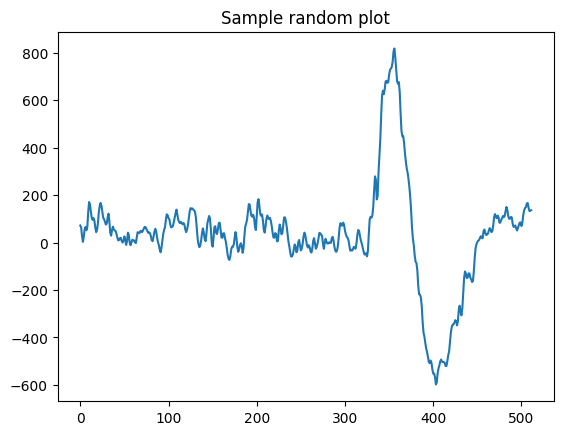

In [6]:

def view_eeg_plot(idx):
    data = eeg.loc[idx, "raw_values"]
    plt.plot(data)
    plt.title(f"Sample random plot")
    plt.show()


view_eeg_plot(7)

## Pre-process and collate data

There are a total of 67 different labels present in the data, where there are numbered
sub-labels. We collate them under a single label as per their numbering and replace them
in the data itself. Following this process, we perform simple Label encoding to get them
in an integer format.

In [7]:
print("Before replacing labels")
print(eeg["label"].unique(), "\n")
print(len(eeg["label"].unique()), "\n")


eeg.replace(
    {
        "label": {
            "blink1": "blink",
            "blink2": "blink",
            "blink3": "blink",
            "blink4": "blink",
            "blink5": "blink",
            "math1": "math",
            "math2": "math",
            "math3": "math",
            "math4": "math",
            "math5": "math",
            "math6": "math",
            "math7": "math",
            "math8": "math",
            "math9": "math",
            "math10": "math",
            "math11": "math",
            "math12": "math",
            "thinkOfItems-ver1": "thinkOfItems",
            "thinkOfItems-ver2": "thinkOfItems",
            "video-ver1": "video",
            "video-ver2": "video",
            "thinkOfItemsInstruction-ver1": "thinkOfItemsInstruction",
            "thinkOfItemsInstruction-ver2": "thinkOfItemsInstruction",
            "colorRound1-1": "colorRound1",
            "colorRound1-2": "colorRound1",
            "colorRound1-3": "colorRound1",
            "colorRound1-4": "colorRound1",
            "colorRound1-5": "colorRound1",
            "colorRound1-6": "colorRound1",
            "colorRound2-1": "colorRound2",
            "colorRound2-2": "colorRound2",
            "colorRound2-3": "colorRound2",
            "colorRound2-4": "colorRound2",
            "colorRound2-5": "colorRound2",
            "colorRound2-6": "colorRound2",
            "colorRound3-1": "colorRound3",
            "colorRound3-2": "colorRound3",
            "colorRound3-3": "colorRound3",
            "colorRound3-4": "colorRound3",
            "colorRound3-5": "colorRound3",
            "colorRound3-6": "colorRound3",
            "colorRound4-1": "colorRound4",
            "colorRound4-2": "colorRound4",
            "colorRound4-3": "colorRound4",
            "colorRound4-4": "colorRound4",
            "colorRound4-5": "colorRound4",
            "colorRound4-6": "colorRound4",
            "colorRound5-1": "colorRound5",
            "colorRound5-2": "colorRound5",
            "colorRound5-3": "colorRound5",
            "colorRound5-4": "colorRound5",
            "colorRound5-5": "colorRound5",
            "colorRound5-6": "colorRound5",
            "colorInstruction1": "colorInstruction",
            "colorInstruction2": "colorInstruction",
            "readyRound1": "readyRound",
            "readyRound2": "readyRound",
            "readyRound3": "readyRound",
            "readyRound4": "readyRound",
            "readyRound5": "readyRound",
            "colorRound1": "colorRound",
            "colorRound2": "colorRound",
            "colorRound3": "colorRound",
            "colorRound4": "colorRound",
            "colorRound5": "colorRound",
        }
    },
    inplace=True,
)

print("After replacing labels")
print(eeg["label"].unique())
print(len(eeg["label"].unique()))

le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(eeg["label"])
eeg["label"] = le.transform(eeg["label"])

Before replacing labels
['blinkInstruction' 'blink1' 'blink2' 'blink3' 'blink4' 'blink5'
 'relaxInstruction' 'relax' 'mathInstruction' 'math1' 'math2' 'math3'
 'math4' 'math5' 'math6' 'math7' 'math8' 'math9' 'math10' 'math11'
 'math12' 'musicInstruction' 'music' 'videoInstruction' 'video-ver1'
 'thinkOfItemsInstruction-ver1' 'thinkOfItems-ver1' 'colorInstruction1'
 'colorInstruction2' 'readyRound1' 'colorRound1-1' 'colorRound1-2'
 'colorRound1-3' 'colorRound1-4' 'colorRound1-5' 'colorRound1-6'
 'readyRound2' 'colorRound2-1' 'colorRound2-2' 'colorRound2-3'
 'colorRound2-4' 'colorRound2-5' 'colorRound2-6' 'readyRound3'
 'colorRound3-1' 'colorRound3-2' 'colorRound3-3' 'colorRound3-4'
 'colorRound3-5' 'colorRound3-6' 'readyRound4' 'colorRound4-1'
 'colorRound4-2' 'colorRound4-3' 'colorRound4-4' 'colorRound4-5'
 'colorRound4-6' 'readyRound5' 'colorRound5-1' 'colorRound5-2'
 'colorRound5-3' 'colorRound5-4' 'colorRound5-5' 'colorRound5-6'
 'video-ver2' 'thinkOfItemsInstruction-ver2' 'thinkOfI

We extract the number of unique classes present in the data

In [8]:
num_classes = len(eeg["label"].unique())
print(num_classes)

19


We now visualize the number of samples present in each class using a Bar plot.

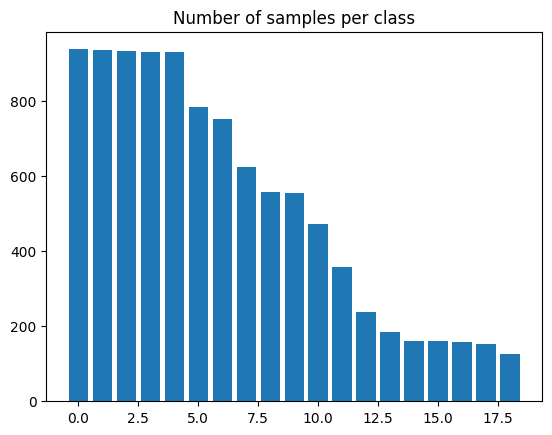

In [9]:
plt.bar(range(num_classes), eeg["label"].value_counts())
plt.title("Number of samples per class")
plt.show()

## Scale and split data

We perform a simple Min-Max scaling to bring the value-range between 0 and 1. We do not
use Standard Scaling as the data does not follow a Gaussian distribution.

In [10]:
scaler = preprocessing.MinMaxScaler()
series_list = [
    scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in eeg["raw_values"]
]

labels_list = [i for i in eeg["label"]]

We now create a Train-test split with a 15% holdout set. Following this, we reshape the
data to create a sequence of length 512. We also convert the labels from their current
label-encoded form to a one-hot encoding to enable use of several different
`keras.metrics` functions.

In [11]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    series_list, labels_list, test_size=0.15, random_state=42, shuffle=True
)

print(
    f"Length of x_train : {len(x_train)}\nLength of x_test : {len(x_test)}\nLength of y_train : {len(y_train)}\nLength of y_test : {len(y_test)}"
)

x_train = np.asarray(x_train).astype(np.float32).reshape(-1, 512, 1)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, 512, 1)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

Length of x_train : 8460
Length of x_test : 1494
Length of y_train : 8460
Length of y_test : 1494


## Prepare `tf.data.Dataset`

We now create a `tf.data.Dataset` from this data to prepare it for training. We also
shuffle and batch the data for use later.

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Make Class Weights using Naive method

As we can see from the plot of number of samples per class, the dataset is imbalanced.
Hence, we **calculate weights for each class** to make sure that the model is trained in
a fair manner without preference to any specific class due to greater number of samples.

We use a naive method to calculate these weights, finding an **inverse proportion** of
each class and using that as the weight.

In [13]:
vals_dict = {}
for i in eeg["label"]:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)

{1: 0.9872413100261201, 0: 0.975989551938919, 14: 0.9841269841269842, 13: 0.9061683745228049, 9: 0.9838255977496484, 8: 0.9059674502712477, 11: 0.9847297568816556, 10: 0.9063692987743621, 18: 0.9838255977496484, 17: 0.9057665260196905, 16: 0.9373116335141651, 15: 0.9065702230259193, 2: 0.9211372312638135, 12: 0.9525818766325096, 3: 0.9245529435402853, 4: 0.943841671689773, 5: 0.9641350210970464, 6: 0.981514968856741, 7: 0.9443439823186659}


## Define simple function to plot all the metrics present in a `keras.callbacks.History`
object

In [15]:

def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()


## Define function to generate Convolutional model

In [16]:

def create_model():
    input_layer = keras.Input(shape=(512, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024,
        kernel_size=7,
        strides=2,
        activation="relu",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        2048, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        1024, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)


133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - auc_2: 0.6415 - loss: 2.6316 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - top_k_categorical_accuracy: 0.2597 - val_auc_2: 0.6716 - val_loss: 2.7676 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_top_k_categorical_accuracy: 0.2664 - learning_rate: 0.0010


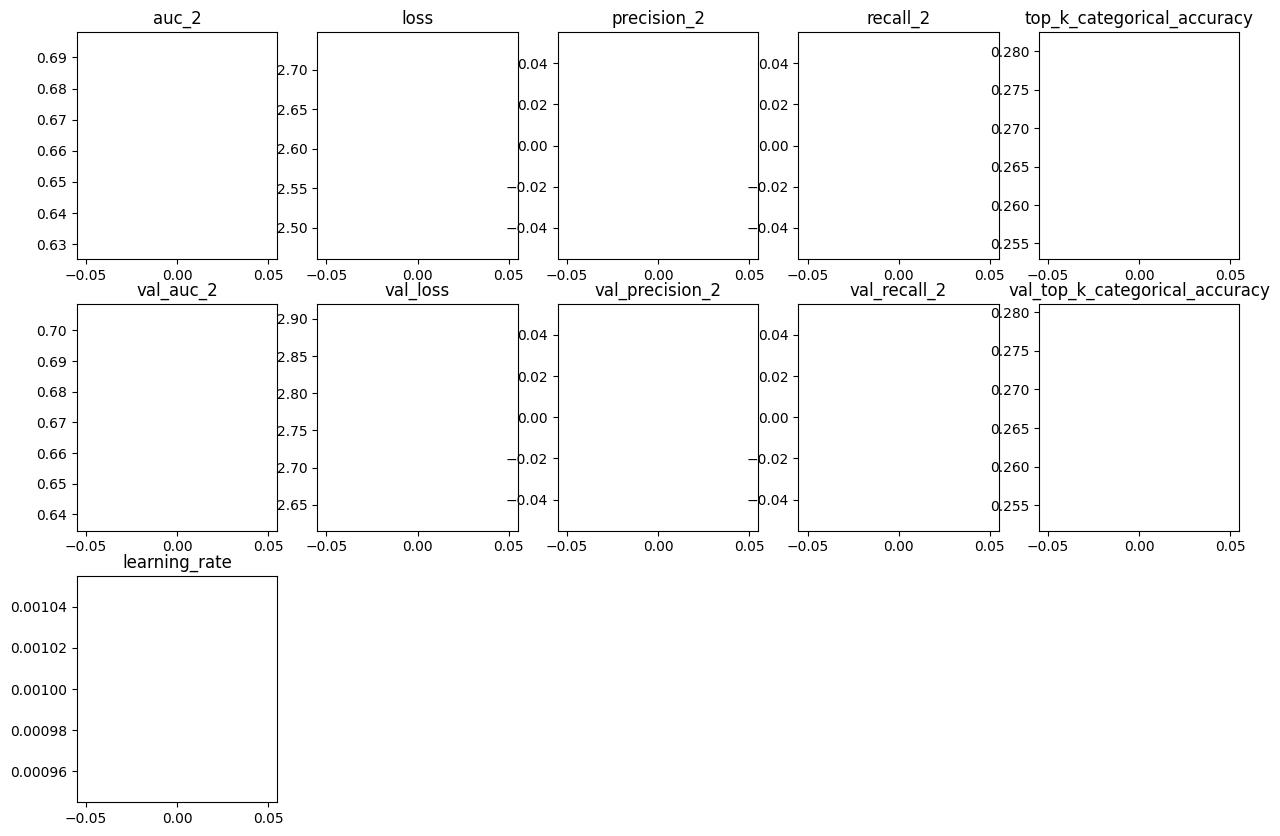

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc_2: 0.6757 - loss: 2.7687 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - top_k_categorical_accuracy: 0.2839
Loss : 2.7676162719726562
Top 3 Categorical Accuracy : 0.26639893651008606
Area under the Curve (ROC) : 0.6716388463973999
Precision : 0.0
Recall : 0.0


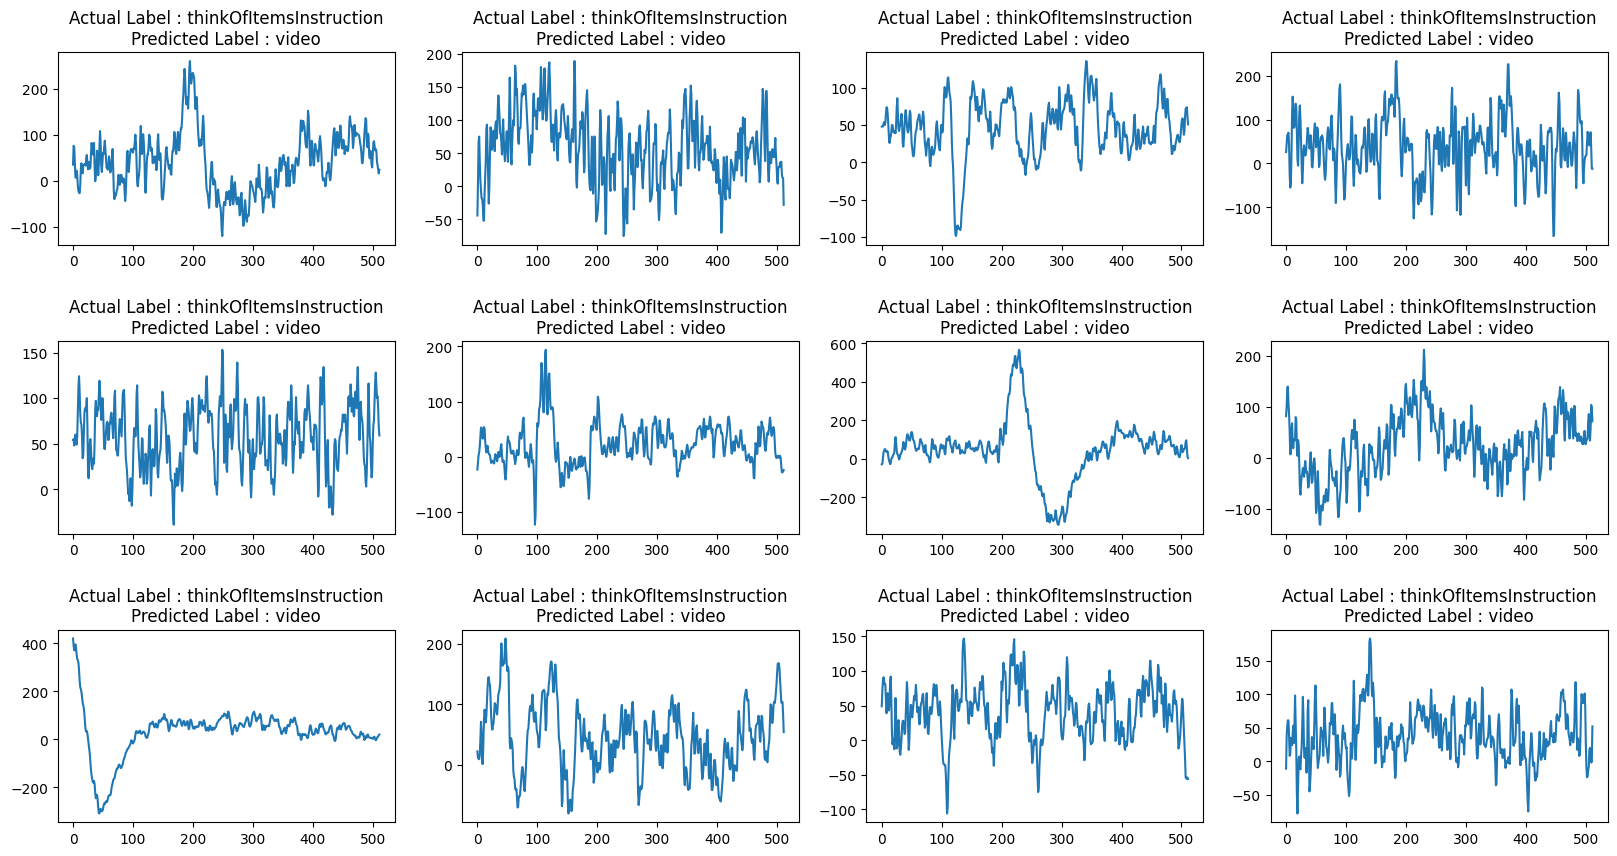

In [23]:
# Define LSTM model
def create_lstm_model():
    input_layer = keras.Input(shape=(512, 1))
    x = layers.LSTM(128, return_sequences=True, activation="tanh")(input_layer)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(64, activation="tanh")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs=input_layer, outputs=output_layer)

# Create, compile, and train the model
lstm_model = create_lstm_model()
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.TopKCategoricalAccuracy(k=3),
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

lstm_model_history = lstm_model.fit(
    train_dataset,
    epochs=1,  # Example: Adjust based on your needs
    callbacks=callbacks,
    validation_data=test_dataset,
    class_weight=weight_dict,
)

# Visualize metrics
plot_history_metrics(lstm_model_history)

# Evaluate the model
loss, accuracy, auc, precision, recall = lstm_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")

# Visualize predictions
view_evaluated_eeg_plots(lstm_model)


133/133 ━━━━━━━━━━━━━━━━━━━━ 59s 250ms/step - auc_4: 0.6229 - loss: 2.6793 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - top_k_categorical_accuracy: 0.2521 - val_auc_4: 0.6691 - val_loss: 2.7836 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_top_k_categorical_accuracy: 0.2664 - learning_rate: 0.0010


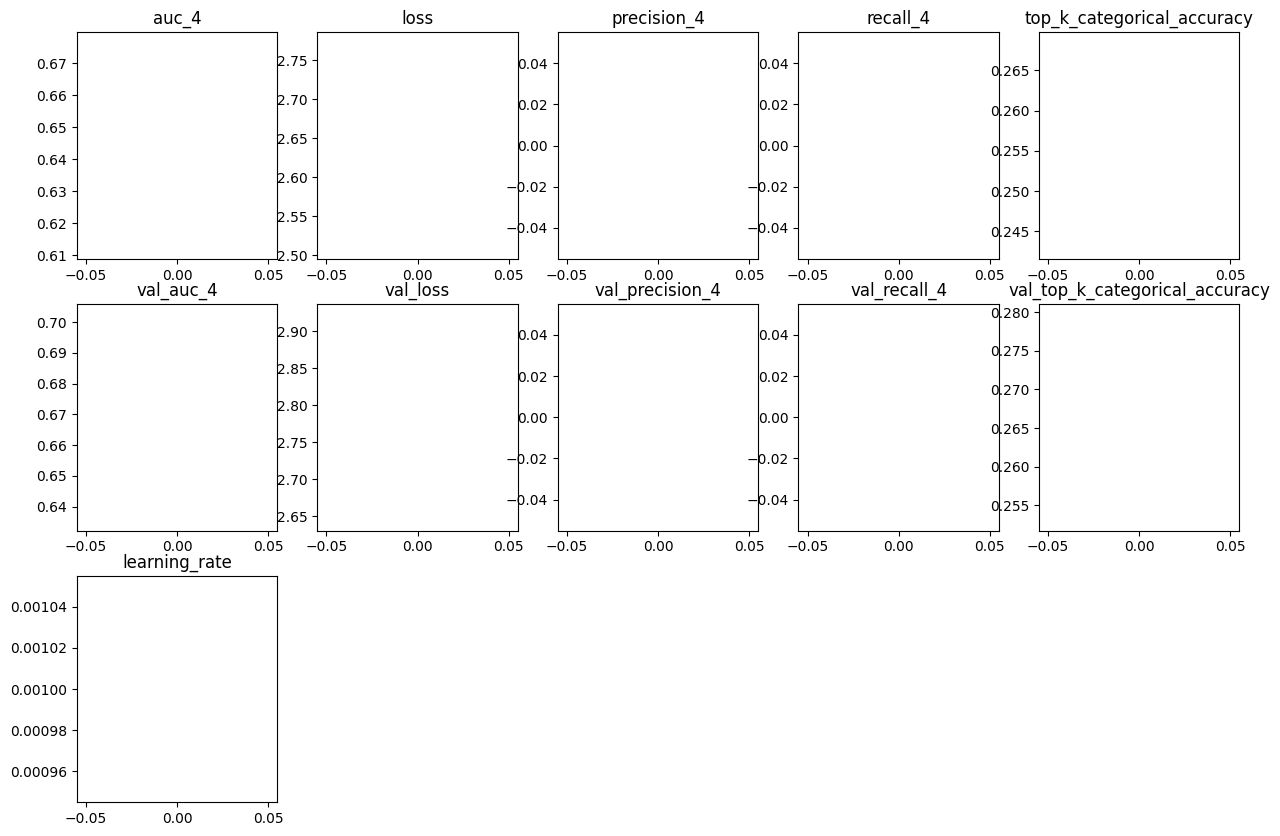

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - auc_4: 0.6722 - loss: 2.7823 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - top_k_categorical_accuracy: 0.2839
Loss : 2.7836155891418457
Top 3 Categorical Accuracy : 0.26639893651008606
Area under the Curve (ROC) : 0.6690632700920105
Precision : 0.0
Recall : 0.0


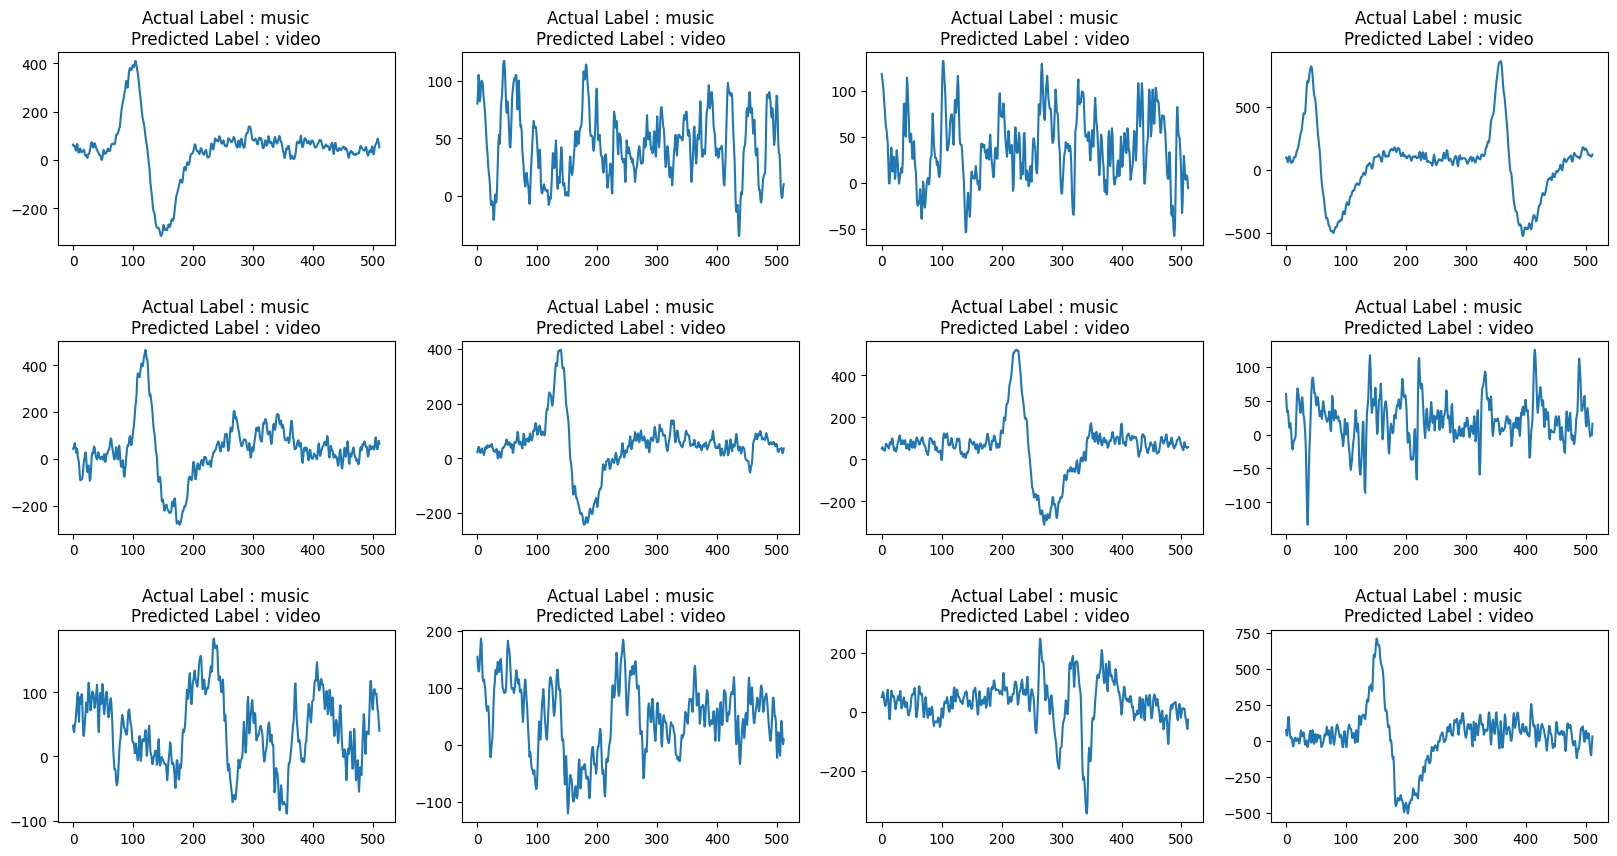

In [26]:
# Define the Transformer model
def transformer_block(inputs, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    output = layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn)
    return output

def attention_pooling(inputs):
    # Learnable weights for attention pooling
    attention_scores = layers.Dense(1, activation="softmax")(inputs)
    weighted_inputs = inputs * attention_scores
    return tf.reduce_sum(weighted_inputs, axis=1)

def positional_encoding(length, depth):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(depth)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(depth))
    pos_encoding = pos * angle_rates
    pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])  # Sine for even indices
    pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])  # Cosine for odd indices
    return tf.constant(pos_encoding[np.newaxis, ...], dtype=tf.float32)

def create_transformer_model():
    input_layer = keras.Input(shape=(512, 1))
    x = layers.Dense(64)(input_layer)

    # Add positional encoding
    pos_encoding = positional_encoding(512, 64)
    x += pos_encoding

    for _ in range(3):  # Add 3 Transformer blocks
        x = transformer_block(x, num_heads=4, ff_dim=128, dropout_rate=0.1)
    #x = layers.GlobalAveragePooling1D()(x)  # Pool across the time dimension
    # Attention pooling instead of global average pooling
    x = attention_pooling(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs=input_layer, outputs=output_layer)

# Create, compile, and train the model
transformer_model = create_transformer_model()
transformer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.TopKCategoricalAccuracy(k=3),
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

transformer_model_history = transformer_model.fit(
    train_dataset,
    epochs=1,
    callbacks=callbacks,
    validation_data=test_dataset,
    class_weight=weight_dict,
)

# Visualize metrics
plot_history_metrics(transformer_model_history)

# Evaluate the model
loss, accuracy, auc, precision, recall = transformer_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")

# Visualize predictions
view_evaluated_eeg_plots(transformer_model)


## Get Model summary

In [17]:
conv_model = create_model()
conv_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 512, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 256, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 128, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 64, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 32, 256)             │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 16, 512)             │         918,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 8, 1024)             │       3,671,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 1024)             │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2048)                │       8,390,656 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 48,989,651 (186.88 MB)

 Trainable params: 48,985,619 (186.87 MB)

 Non-trainable params: 4,032 (15.75 KB)

## Define callbacks, optimizer, loss and metrics

We set the number of epochs at 30 after performing extensive experimentation. It was seen
that this was the optimal number, after performing Early-Stopping analysis as well.
We define a Model Checkpoint callback to make sure that we only get the best model
weights.
We also define a ReduceLROnPlateau as there were several cases found during
experimentation where the loss stagnated after a certain point. On the other hand, a
direct LRScheduler was found to be too aggressive in its decay.

In [18]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_top_k_categorical_accuracy",
        factor=0.2,
        patience=2,
        min_lr=0.000001,
    ),
]

optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()

## Compile model and call `model.fit()`

We use the `Adam` optimizer since it is commonly considered the best choice for
preliminary training, and was found to be the best optimizer.
We use `CategoricalCrossentropy` as the loss as our labels are in a one-hot-encoded form.

We define the `TopKCategoricalAccuracy(k=3)`, `AUC`, `Precision` and `Recall` metrics to
further aid in understanding the model better.

In [19]:
conv_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        keras.metrics.TopKCategoricalAccuracy(k=3),
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

conv_model_history = conv_model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_dataset,
    class_weight=weight_dict,
)

133/133 ━━━━━━━━━━━━━━━━━━━━ 53s 269ms/step - auc: 0.6151 - loss: 24.4365 - precision: 0.0241 - recall: 8.8905e-04 - top_k_categorical_accuracy: 0.2555 - val_auc: 0.6561 - val_loss: 3.9541 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_k_categorical_accuracy: 0.2610 - learning_rate: 0.0010


## Visualize model metrics during training

We use the function defined above to see model metrics during training.

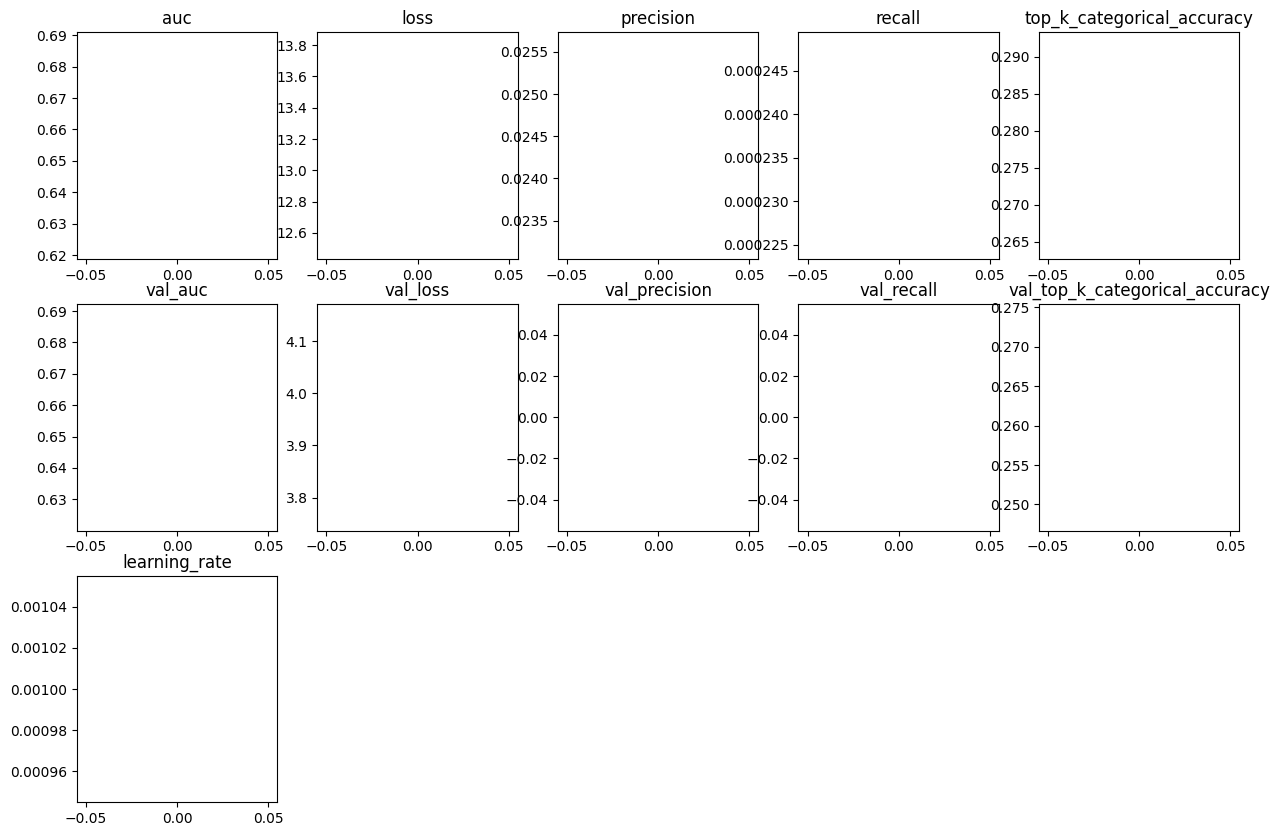

In [20]:
plot_history_metrics(conv_model_history)

## Evaluate model on test data

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6547 - loss: 3.9603 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_k_categorical_accuracy: 0.2645
Loss : 3.9541432857513428
Top 3 Categorical Accuracy : 0.2610441744327545
Area under the Curve (ROC) : 0.6561466455459595
Precision : 0.0
Recall : 0.0


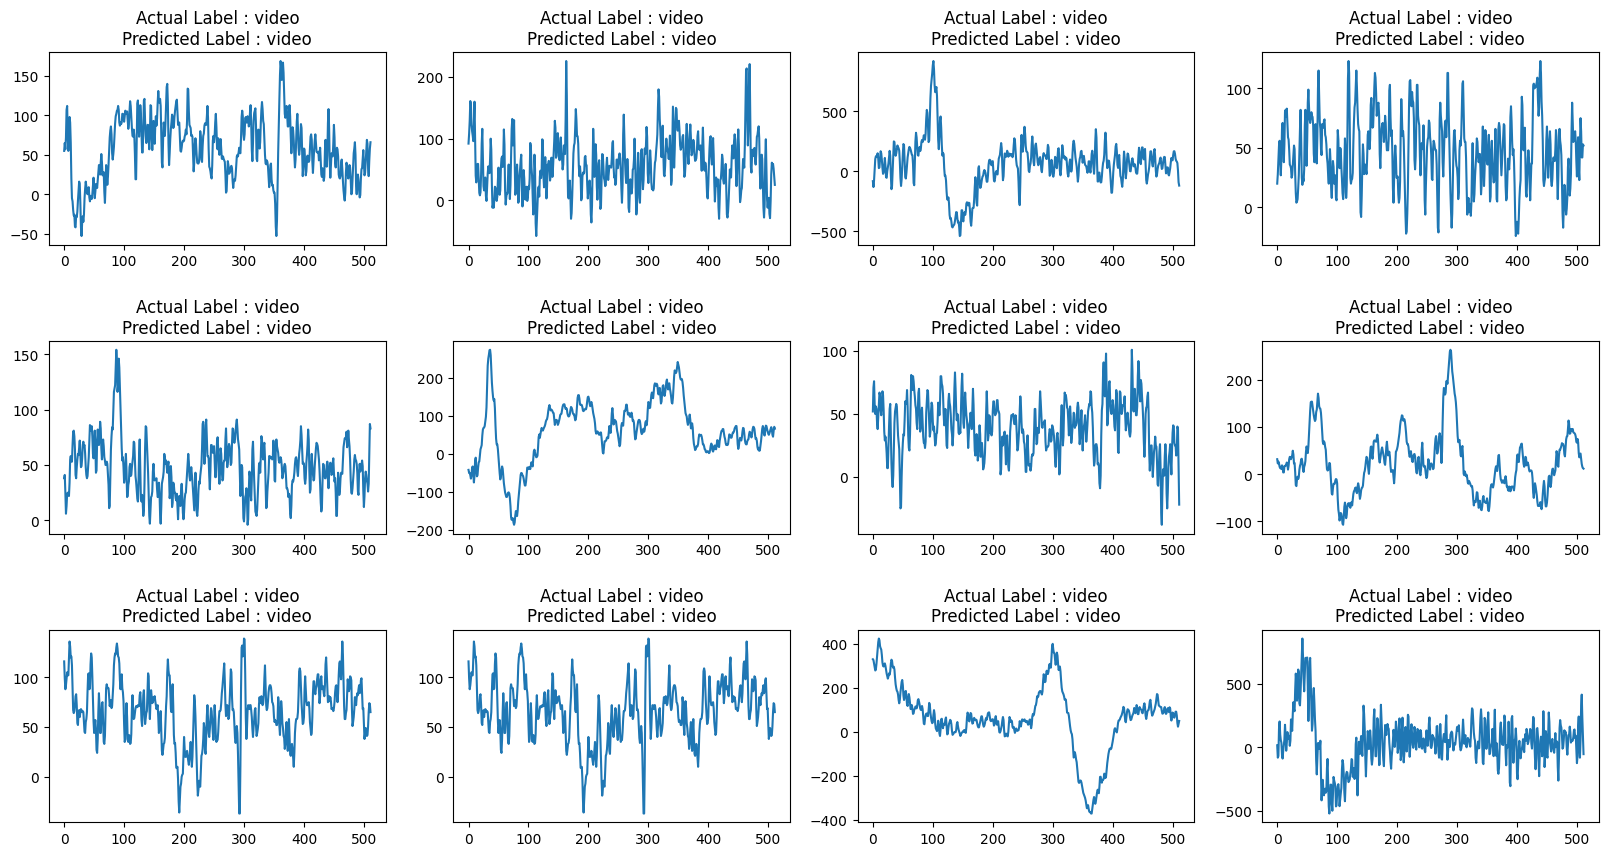

In [21]:
loss, accuracy, auc, precision, recall = conv_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")


def view_evaluated_eeg_plots(model):
    start_index = random.randint(10, len(eeg))
    end_index = start_index + 11
    data = eeg.loc[start_index:end_index, "raw_values"]
    data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
    data_array = [np.asarray(data_array).astype(np.float32).reshape(-1, 512, 1)]
    original_labels = eeg.loc[start_index:end_index, "label"]
    predicted_labels = np.argmax(model.predict(data_array, verbose=0), axis=1)
    original_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in original_labels
    ]
    predicted_labels = [
        le.inverse_transform(np.array(label).reshape(-1))[0]
        for label in predicted_labels
    ]
    total_plots = 12
    cols = total_plots // 3
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1
    pos = range(1, total_plots + 1)
    fig = plt.figure(figsize=(20, 10))
    for i, (plot_data, og_label, pred_label) in enumerate(
        zip(data, original_labels, predicted_labels)
    ):
        plt.subplot(rows, cols, pos[i])
        plt.plot(plot_data)
        plt.title(f"Actual Label : {og_label}\nPredicted Label : {pred_label}")
        fig.subplots_adjust(hspace=0.5)
    plt.show()


view_evaluated_eeg_plots(conv_model)